# Modélisation de la prédiction de tags pour les questions  de Stack Overflow

Ce notebook regroupe les travaux de prétraitement des docuements et les tests des modèles des approches supervisés et non supervisés afin de prédire les tags de Stack Overflow.

In [36]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [37]:
import sys
sys.path.append('/content/gdrive/My Drive/P5')
import contractions
import nlpk_module

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 7.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=874c0c32ed8fc58400acfecbbb3944c58405c34c0a39cd3471d737de9e539581
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 5.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [39]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from nlpk_module import remove_stopwords, plot_top_words, tok, print_score
import sklearn
import time
from datetime import datetime
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics, cluster, preprocessing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pyLDAvis
import pyLDAvis.sklearn
import pickle
from pickle import dump
import joblib


#Data preparation

In [ ]:
path= "/content/gdrive/My Drive/P5/data_with_tags_frequent.csv"
data = pd.read_csv(path, encoding="utf-8")
data.head(3)

,Title,Body,Tags
0,static option gcc,wonder static option gcc need option compile c...,"optimization, gcc, compiler-construction, sta..."
1,file group record unit separator control chara...,unicode define several control character ascii...,"text, unicode, ascii, history, control-charac..."
2,read file line line go,unable find file readline function go one read...,"string, file, parsing, go, line"


suppression des valeurs manquantes

In [ ]:
data.dropna(inplace=True)

De plus, nous décidons de considérer le titre et le corps comme un texte entier. Nous regroupons ces données dans une nouvelle variable nommée "docs".

In [ ]:
docs = data["Title"].values + " " + data["Body"].values

Afin de pouvoir entraîner les modèles supervisées nous avons besoin de transformer les listes de tokens lemmatisés en vecteurs. Plusieurs méthodes sont couramment utilisées :
- TF-IDF, USE, W2V et BERT


Enfin de réaliser une première classification avec NMF, le vectoriseur choisi est TF-IDF.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
tfidf = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

## I Modèles supervisés

- **Modélisation with TF-IDF**

Multi-labelisation des top tags

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
tags = data["Tags"].apply(lambda x: x[0:].split(','))

mlb = MultiLabelBinarizer()
mlb.fit(tags.astype(str))
tags_mlb = mlb.transform(tags.astype(str))

Nous conservons 75% des données pour le jeu d’entraînement et 25% pour le jeu de test.

In [ ]:
from sklearn.model_selection import train_test_split

X = docs
y = tags_mlb

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.25)

In [ ]:
results1=pd.DataFrame()

In [ ]:
from sklearn.metrics import make_scorer, f1_score
scorer_multilabel = make_scorer(f1_score,
                                average="micro")

**1-LogisticRegression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
forest_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf',OneVsRestClassifier(LogisticRegression(random_state = 1)))])

solver=['sag']
penalty=['l1','l2']
C=[100, 10, 1.0, 0.1] 
min_df=[0.001,0.01,1]
max_df=[0.001,0.01,1]
#use=[False,True]
n_gram_range=[(1, 1)]
tokenize=['tok',None]
tfidf__max_features=[12000,None]
n_jobs=[-1]
hyperF = dict(clf__estimator__C=C,clf__estimator__penalty=penalty,
              clf__estimator__solver=solver,tfidf__min_df=min_df,tfidf__max_df=max_df,#tfidf__use_idf=use,
              tfidf__max_features=tfidf__max_features,#clf__estimator__min_samples_leaf=min_samples_leaf,
              clf__n_jobs=n_jobs,tfidf__tokenizer=tokenize,tfidf__ngram_range=n_gram_range)

gridL = GridSearchCV(forest_pipeline,hyperF,cv = 5,scoring=scorer_multilabel)

training_start_L= time.perf_counter()
gridL.fit(X_train,y_train)
training_end_L = time.perf_counter() 

In [ ]:
cv_mean=gridL.cv_results_['mean_test_score']
cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
cv_mean

0.8412067534034917

In [ ]:
gridL.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.01, max_features=12000,
                                 min_df=0.001)),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(C=100,
                                                                  random_state=1,
                                                                  solver='sag'),
                                     n_jobs=-1))])

In [ ]:
gridL.best_params_

{'clf__estimator__C': 100,
 'clf__estimator__penalty': 'l2',
 'clf__estimator__solver': 'sag',
 'clf__n_jobs': -1,
 'tfidf__max_df': 0.01,
 'tfidf__max_features': 12000,
 'tfidf__min_df': 0.001,
 'tfidf__ngram_range': (1, 1),
 'tfidf__tokenizer': None}

In [ ]:
gridL_train_time=training_end_L - training_start_L
results1=results1.append(pd.DataFrame({'Feature extraction':['Tfidf'],
    'Modèle' : ['Logistic Regression'],
    'Train_Score' : [gridL.score(X_train,y_train)],'cv_scores_mean_':[cv_mean],'Time_train':[gridL_train_time]}),ignore_index=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**2-Radomforest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
forest_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf',OneVsRestClassifier(RandomForestClassifier(random_state = 1)))])

n_estimators = [20]
max_features = ['sqrt',None]
criterion=['gini']
#min_samples_split = [2, 5, 10, 15, 40]
#min_samples_leaf = [1, 2, 5, 10] 
min_df=[0.001,0.01,1]
max_df=[0.001,0.01,1]
#use=[False,True]
n_gram_range=[(1, 1)]
tokenize=['tok',None]
tfidf__max_features=[12000,None]
n_jobs=[-1]
hyperF = dict(clf__estimator__n_estimators=n_estimators,clf__estimator__max_features=max_features,
              clf__estimator__criterion=criterion,tfidf__min_df=min_df,tfidf__max_df=max_df,#tfidf__use_idf=use,
              tfidf__max_features=tfidf__max_features,#clf__estimator__min_samples_leaf=min_samples_leaf,
              #clf__estimator__min_samples_split=min_samples_split,
              clf__n_jobs=n_jobs,tfidf__tokenizer=tokenize,tfidf__ngram_range=n_gram_range)

gridF = GridSearchCV(forest_pipeline,hyperF,cv = 5,scoring=scorer_multilabel)

training_start_F= time.perf_counter()
gridF.fit(X_train,y_train)
training_end_F = time.perf_counter() 

In [ ]:
cv_mean=gridF.cv_results_['mean_test_score']
cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
cv_mean

0.812111413513014

In [ ]:
gridF.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=1, max_features=12000, min_df=0.001)),
                ('clf',
                 OneVsRestClassifier(estimator=RandomForestClassifier(max_features='sqrt',
                                                                      n_estimators=20,
                                                                      random_state=1),
                                     n_jobs=-1))])

In [ ]:
gridF.best_params_

{'clf__estimator__criterion': 'gini',
 'clf__estimator__max_features': 'sqrt',
 'clf__estimator__n_estimators': 20,
 'clf__n_jobs': -1,
 'tfidf__max_df': 1,
 'tfidf__max_features': 12000,
 'tfidf__min_df': 0.001,
 'tfidf__ngram_range': (1, 1),
 'tfidf__tokenizer': None}

In [ ]:
gridF_train_time=training_end_F - training_start_F
results1=results1.append(pd.DataFrame({'Feature extraction':['Tfidf'],
    'Modèle' : ['Random Forest classifier'],
    'Train_Score' : [gridF.score(X_train,y_train)],'cv_scores_mean_':[cv_mean],'Time_train':[gridF_train_time]}),ignore_index=True)

**3-Passive Aggressive Classifier**

In [ ]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.multiclass import OneVsRestClassifier
pac_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer()),
                ('clf',OneVsRestClassifier(PassiveAggressiveClassifier(random_state=1)))])

max_iter=[50,100]
n_gram_range=[(1, 1),(1,2)]
tokenize=['tok',None]
min_df=[0.001,0.01,1]
max_df=[0.001,0.01,1]
use=[True,False]
tfidf__max_features=[12000,None]
n_jobs=[-1]
hyperF = dict(clf__estimator__max_iter=max_iter,tfidf__max_features=tfidf__max_features,
              clf__n_jobs=n_jobs,tfidf__tokenizer=tokenize,tfidf__min_df=min_df,tfidf__max_df=max_df,tfidf__ngram_range=n_gram_range)

gridpac = GridSearchCV(pac_pipeline,hyperF,cv = 5,scoring=scorer_multilabel)

training_start_p= time.perf_counter()
gridpac.fit(X_train,y_train)
training_end_p = time.perf_counter() 

In [ ]:
cv_mean=gridpac.cv_results_['mean_test_score']
cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
cv_mean

0.7528710722138018

In [ ]:
gridpac.best_estimator_

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.01, max_features=12000,
                                 min_df=0.001)),
                ('clf',
                 OneVsRestClassifier(estimator=PassiveAggressiveClassifier(max_iter=50,
                                                                           random_state=1),
                                     n_jobs=-1))])

In [ ]:
gridpac.best_params_

{'clf__estimator__max_iter': 50,
 'clf__n_jobs': -1,
 'tfidf__max_df': 0.01,
 'tfidf__max_features': 12000,
 'tfidf__min_df': 0.001,
 'tfidf__ngram_range': (1, 1),
 'tfidf__tokenizer': None}

In [ ]:
gridpac_train_time=training_end_p - training_start_p
results1=results1.append(pd.DataFrame({'Feature extraction':['Tfidf'],
    'Modèle' : ['Passive agrasive classifier'],
    'Train_Score' : [gridpac.score(X_train,y_train)],'cv_scores_mean_':[cv_mean],'Time_train':[gridpac_train_time]}),ignore_index=True)

* **Synthèse des résultats**

In [ ]:
results1

,Feature extraction,Modèle,Train_Score,cv_scores_mean_,Time_train
0,Tfidf,Logistic Regression,0.999544,0.815437,278.910397
1,Tfidf,Random Forest classifier,0.990630,0.812111,681.736567
2,Tfidf,Passive agrasive classifier,0.999413,0.752871,64.481005


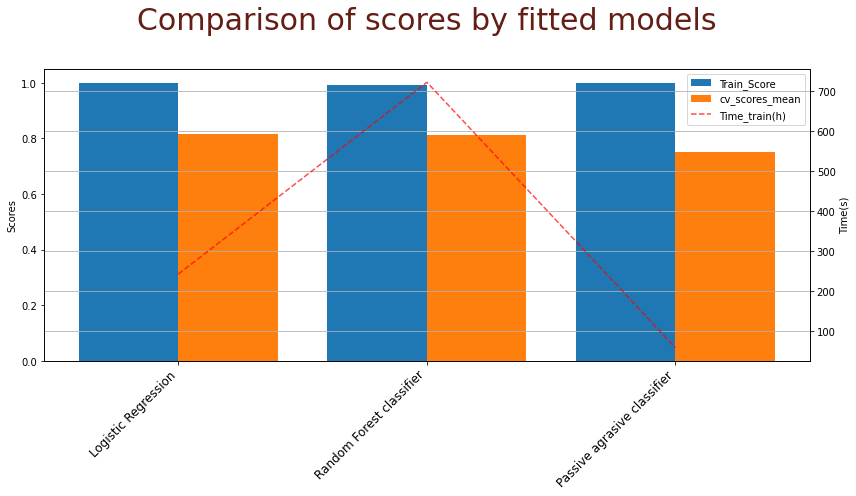

In [ ]:
x = np.arange(len(results1.iloc[:,1]))
width = 0.4

fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111)
train_scores = ax1.bar(x - width/2, results1.iloc[:,2], width, label="Train_Score")
cv_scores = ax1.bar(x + width/2,  results1.iloc[:,3], width, label="cv_scores_mean")

ax2 = ax1.twinx()
ax2.set_ylabel('Time(s)')
time = ax2.plot(x, [242.13,721.69,58.03],
                       linestyle='--',
                       color="red", alpha=.7,
                       label='Time_train(h)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="#641E16", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(labels = results1.iloc[:,1], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc=0,
           fontsize=10)

fig.tight_layout()

plt.show()

Le modèle Logistic regresion possede les bonnes performances sur les score d'entrainement et cv_mean_score.Ce modèle minise  le cout en temps et le risque de Overfiting.
- Modèle choisit : **Logistic regresion**

In [ ]:
# save best model

joblib.dump(gridL.best_estimator_,'/content/gdrive/My Drive/P5/L_best.pkl')

['/content/gdrive/My Drive/P5/L_best.pkl']

In [ ]:
Lg_r= joblib.load('/content/gdrive/My Drive/P5/L_best.pkl')

- Evaluation du meilleur modèle

In [ ]:
from numpy.lib.function_base import average
def Performance_score(feature,name_model,model,X_test,y_true):
  y_pred=model.predict(X_test)
  
  temp_df = pd.DataFrame({'Score':['hamming_loss',"Jaccard", "F1-score",
                                  ]})
  scores = []
  scores.append(metrics.hamming_loss(y_true, y_pred))
  scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='micro'))
  scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='micro'))
  
  temp_df[name_model + ' + ' + feature ] = scores  
  return temp_df

In [ ]:
df_performance_score=Performance_score('tfidf','LogisticRegression',Lg_r,X_test,y_test)
df_performance_score

,Score,LogisticRegression + tfidf
0,hamming_loss,0.160580
1,Jaccard,0.693543
2,F1-score,0.819044


In [ ]:

dump(df_performance_score, open('/content/gdrive/My Drive/P5/df_performance_score.pkl', 'wb'))

In [ ]:
ds= joblib.load('/content/gdrive/My Drive/P5/df_performance_score.pkl')

- **Modélisation with USE**

In [ ]:
# Load BERT from the Tensorflow Hub
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    
    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))
    return features

In [ ]:
b_size=7
X_train_use=feature_USE_fct(X_train,b_size)
X_test_use=feature_USE_fct(X_test,b_size)


In [ ]:
from pandas.core.common import random_state
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import timeit
import itertools
import pickle


In [ ]:
from sklearn.metrics import make_scorer, f1_score
scorer_multilabel = make_scorer(f1_score,
                                average="micro")

In [ ]:
DICT_CLF = {#'nbc': {'clf': MultinomialNB(),
                   #'params': {'model__estimator__alpha':[0.3, 0.5, 0.7, 1.0],'model__estimator__fit_prior':[True,False]}},
            
            'lr': {'clf': LogisticRegression(random_state=1),'params':{'model__estimator__solver': ['sag'],'model__estimator__penalty': ['l1','l2'],
                      'model__estimator__C': [100, 10, 1.0, 0.1]}},

            'rfc': {'clf': RandomForestClassifier(random_state=1), 
                  'params': {#'model__estimator__max_features':['sqrt',None],
                             'model__estimator__min_samples_leaf' : [1, 2, 5, 10],
                              'model__estimator__criterion': ['entropy', 'gini'], 
                              'model__estimator__n_estimators': [50],}},
             
            'pac': {'clf': PassiveAggressiveClassifier(random_state=1), 
                    'params': {'model__estimator__max_iter':[50,100],'model__estimator__tol':[1e-2,1e-3] }}, 
            
            }

In [ ]:
dict_results = {}
dic_model={}
for k, v in DICT_CLF.items():
    clf = Pipeline([('model',OneVsRestClassifier(v['clf']))])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_results[clf_name] = {}

    start_time = timeit.default_timer()
    gs = GridSearchCV(clf, v['params'], cv=5, scoring=scorer_multilabel)
    gs.fit(X_train_use, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_results[clf_name]['clf'] = gs.fit(X_train_use, y_train)

    #y_pred = clf.predict(X_test_use)
    elapsed = timeit.default_timer() - start_time

    train_score = gs.score(X_train_use, y_train)
    cv_mean=gs.cv_results_['mean_test_score']
    cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
    print("Train time : {:.4f}s".format(elapsed))    
    print("Train score: {:.4f}".format(train_score))    
    print("cv_mean score: {:.4f}\n".format(cv_mean))
    dict_results[clf_name]['Feature extraction']='USE'
    dict_results[clf_name]['Train score'] =train_score
    dict_results[clf_name]['CV_mean score'] = cv_mean
    dict_results[clf_name]['Train time'] = elapsed
    

LogisticRegression
------------------------------
Best params: {'model__estimator__C': 1.0, 'model__estimator__penalty': 'l2', 'model__estimator__solver': 'sag'} 

Train time : 149.5551s
Train score: 0.8565
cv_mean score: 0.8142

RandomForestClassifier
------------------------------
Best params: {'model__estimator__criterion': 'entropy', 'model__estimator__min_samples_leaf': 5, 'model__estimator__n_estimators': 50} 

Train time : 794.9763s
Train score: 0.9699
cv_mean score: 0.8367

PassiveAggressiveClassifier
------------------------------
Best params: {'model__estimator__max_iter': 50, 'model__estimator__tol': 0.01} 

Train time : 31.5289s
Train score: 0.9914
cv_mean score: 0.7819



In [ ]:
results=pd.DataFrame(dict_results)
results.iloc[1:,:]

,LogisticRegression,RandomForestClassifier,PassiveAggressiveClassifier
Feature extraction,USE,USE,USE
Train score,0.856517,0.969858,0.991392
CV_mean score,0.814235,0.836749,0.781891
Train time,149.555092,794.976325,31.528861


Le modèle Logistic regresion possede les bonnes performances sur les score d'entrainement et cv_mean_score.Ce modèle minise  le cout en temps et le risque de Overfiting.
- Modèle choisit : **Logistic Regression**

In [ ]:
# save best model
import joblib
joblib.dump(results.iloc[0,:][0].best_estimator_,'/content/gdrive/My Drive/P5/L_best_use.pkl')
Lg_r_use= joblib.load('/content/gdrive/My Drive/P5/L_best_use.pkl')

- **Evaluation du meilleur modèle**

In [ ]:
df_performance_score1=Performance_score('USE','LogisticRegression',Lg_r_use,X_test_use,y_test)
df_performance_score1

,Score,LogisticRegression + USE
0,hamming_loss,0.158074
1,Jaccard,0.690175
2,F1-score,0.816691


- Modélisation with WORD2VEC

In [ ]:
from gensim.models import Word2Vec
vec_model = Word2Vec(docs,vector_size=100,min_count=2)
w2v = dict(zip(vec_model.wv.index_to_key, vec_model.wv.vectors))

In [ ]:
class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])

In [ ]:
DICT_CLF = {#'nbc': {'clf': MultinomialNB(),
                   #'params': {'model__estimator__alpha':[0.3, 0.5, 0.7, 1.0],'model__estimator__fit_prior':[True,False]}},
            
            'lr': {'clf': LogisticRegression(random_state=1),'params':{'model__estimator__solver': ['sag'],'model__estimator__penalty': ['l1','l2'],
                      'model__estimator__C': [100, 10, 1.0, 0.1]}},

            'rfc': {'clf': RandomForestClassifier(random_state=1), 
                  'params': {#'model__estimator__max_features':['sqrt',None],
                             'model__estimator__min_samples_leaf' : [1, 2, 5, 10],
                              'model__estimator__criterion': ['entropy', 'gini'], 
                              'model__estimator__n_estimators': [50],}},
             
            'pac': {'clf': PassiveAggressiveClassifier(random_state=1), 
                    'params': {'model__estimator__max_iter':[50,100],'model__estimator__tol':[1e-2,1e-3] }}, 
            
            }

In [ ]:
dict_results = {}
for k, v in DICT_CLF.items():
    clf = Pipeline([('vec', Vectorizer(w2v)),('model',OneVsRestClassifier(v['clf']))])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_results[clf_name] = {}

    start_time = timeit.default_timer()
    gs = GridSearchCV(clf, v['params'], cv=5, scoring=scorer_multilabel)
    gs.fit(X_train, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_results[clf_name]['clf'] = gs.fit(X_train, y_train)

    #y_pred = clf.predict(X_test_use)
    elapsed = timeit.default_timer() - start_time

    train_score = gs.score(X_train, y_train)
    cv_mean=gs.cv_results_['mean_test_score']
    cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
    print("Train time : {:.4f}s".format(elapsed))    
    print("Train score: {:.4f}".format(train_score))    
    print("cv_mean score: {:.4f}\n".format(cv_mean))

    dict_results[clf_name]['Feature extraction']='Word2Vec'
    dict_results[clf_name]['Train score'] =train_score
    dict_results[clf_name]['CV_mean score'] = cv_mean
    dict_results[clf_name]['Train time'] = elapsed
    

LogisticRegression
------------------------------
Best params: {'model__estimator__C': 100, 'model__estimator__penalty': 'l2', 'model__estimator__solver': 'sag'} 

Train time : 60.4569s
Train score: 0.8303
cv_mean score: 0.8140

RandomForestClassifier
------------------------------
Best params: {'model__estimator__criterion': 'gini', 'model__estimator__min_samples_leaf': 10, 'model__estimator__n_estimators': 50} 

Train time : 504.4139s
Train score: 0.8984
cv_mean score: 0.8293

PassiveAggressiveClassifier
------------------------------
Best params: {'model__estimator__max_iter': 50, 'model__estimator__tol': 0.01} 

Train time : 11.9001s
Train score: 0.8128
cv_mean score: 0.7637



In [ ]:
results=pd.DataFrame(dict_results)
results.iloc[1:,:]

,LogisticRegression,RandomForestClassifier,PassiveAggressiveClassifier
Feature extraction,Word2Vec,Word2Vec,Word2Vec
Train score,0.830325,0.898399,0.81281
CV_mean score,0.813958,0.82932,0.763666
Train time,60.456901,504.413867,11.900113


Le modèle LogisticRegression  possede les bonnes performances sur les score d'entrainement et cv_mean_score.Ce modèle minimise  le cout en temps et le risque de Overfiting.
- Modèle choisit : **Logistic Regression**

In [ ]:
# save best model
import joblib
joblib.dump(results.iloc[0,:][0].best_estimator_,'/content/gdrive/My Drive/P5/L_best_wv.pkl')
Lg_r_wv= joblib.load('/content/gdrive/My Drive/P5/L_best_wv.pkl')

- **Evaluation du meilleur modèle**

In [ ]:
df_performance_score2=Performance_score('W2Vec','LogisticRegression',Lg_r_wv,X_test,y_test)
df_performance_score2

,Score,LogisticRegression + W2Vec
0,hamming_loss,0.161833
1,Jaccard,0.685237
2,F1-score,0.813223


- **Modélisation with BERT**

In [ ]:
!pip install --upgrade transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 20.6 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 101 kB 10.1 MB/s 
     |████████████████████████████████| 6.6 MB 47.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import AutoTokenizer, AutoConfig, TFAutoModel    

#from transformers import *
os.environ["TF_KERAS"]='1'

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    #time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    #time2 = np.round(time.time() - time1,0)
    #print("temps traitement : ", time2)
     
    return features_bert

In [ ]:
import tensorflow_hub as hub
# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [ ]:
max_length = 64
batch_size = 7
model_type = 'bert-base-uncased'
model = bert_layer
y_train_bert=y_train
y_test_bert=y_test
X_train_bert= feature_BERT_fct(model, model_type,X_train,max_length, batch_size, mode='TFhub')
X_test_bert= feature_BERT_fct(model, model_type,X_test,max_length, batch_size, mode='TFhub')

In [ ]:
DICT_CLF = {#'nbc': {'clf': MultinomialNB(),
                   #'params': {'model__estimator__alpha':[0.3, 0.5, 0.7, 1.0],'model__estimator__fit_prior':[True,False]}},
            
            'lr': {'clf': LogisticRegression(random_state=1),'params':{'model__estimator__solver': ['sag'],'model__estimator__penalty': ['l1','l2'],
                      'model__estimator__C': [100, 10, 1.0, 0.1]}},

            'rfc': {'clf': RandomForestClassifier(random_state=1), 
                  'params': {#'model__estimator__max_features':['sqrt',None],
                             'model__estimator__min_samples_leaf' : [1, 2, 5, 10],
                              'model__estimator__criterion': ['entropy', 'gini'], 
                              'model__estimator__n_estimators': [50],}},
             
            'pac': {'clf': PassiveAggressiveClassifier(random_state=1), 
                    'params': {'model__estimator__max_iter':[50,100],'model__estimator__tol':[1e-2,1e-3] }}, 
            
            }

In [ ]:
dict_results = {}
dic_model={}
for k, v in DICT_CLF.items():
    clf = Pipeline([('model',OneVsRestClassifier(v['clf']))])
    clf_name = v['clf'].__class__.__name__
    print('{}\n{}\n{}'.format('='*30, clf_name, '-'*30))
    dict_results[clf_name] = {}

    start_time = timeit.default_timer()
    gs = GridSearchCV(clf, v['params'], cv=5, scoring=scorer_multilabel)
    gs.fit(X_train_use, y_train)
    print("Best params:", gs.best_params_, '\n')
    dict_results[clf_name]['clf'] = gs.fit(X_train_bert, y_train)

    #y_pred = clf.predict(X_test_use)
    elapsed = timeit.default_timer() - start_time

    train_score = gs.score(X_train_bert, y_train)
    cv_mean=gs.cv_results_['mean_test_score']
    cv_mean = cv_mean[np.logical_not(np.isnan(cv_mean))].mean()
    print("Train time : {:.4f}s".format(elapsed))    
    print("Train score: {:.4f}".format(train_score))    
    print("cv_mean score: {:.4f}\n".format(cv_mean))
    
    dict_results[clf_name]['Feature extraction']='BERT'
    dict_results[clf_name]['Train score'] =train_score
    dict_results[clf_name]['CV_mean score'] = cv_mean
    dict_results[clf_name]['Train time'] = elapsed
    

LogisticRegression
------------------------------
Best params: {'model__estimator__C': 1.0, 'model__estimator__penalty': 'l2', 'model__estimator__solver': 'sag'} 

Train time : 313.3879s
Train score: 0.8636
cv_mean score: 0.8023

RandomForestClassifier
------------------------------
Best params: {'model__estimator__criterion': 'entropy', 'model__estimator__min_samples_leaf': 5, 'model__estimator__n_estimators': 50} 

Train time : 792.9405s
Train score: 0.9539
cv_mean score: 0.8326

PassiveAggressiveClassifier
------------------------------
Best params: {'model__estimator__max_iter': 50, 'model__estimator__tol': 0.01} 

Train time : 45.0286s
Train score: 0.9311
cv_mean score: 0.7646



In [ ]:
results=pd.DataFrame(dict_results)
results.iloc[1:,:]

,LogisticRegression,RandomForestClassifier,PassiveAggressiveClassifier
Feature extraction,BERT,BERT,BERT
Train score,0.863605,0.953878,0.931063
CV_mean score,0.802301,0.832573,0.764601
Train time,313.387904,792.94048,45.028636


RandomForestClassifier possede les meilleurs performances sur les scores d'entrainement et cv_mean_score  mais il presente un risque d'Overfiting et un cout important en temps. Par contre logistic regression  minimise ce risque bien que très couteux en temps.
- Modèle choisit : **Logistic Regression**

In [ ]:
# save best model
import joblib
joblib.dump(results.iloc[0,:][0].best_estimator_,'/content/gdrive/My Drive/P5/L_best_bert.pkl')
Lg_r_bert= joblib.load('/content/gdrive/My Drive/P5/L_best_bert.pkl')

- **Evaluation du meilleur modèle**

In [ ]:
df_performance_score3=Performance_score('BERT','LogisticRegression',Lg_r_bert,X_test_bert,y_test_bert)
df_performance_score3

,Score,LogisticRegression + BERT
0,hamming_loss,0.157358
1,Jaccard,0.693408
2,F1-score,0.818950


- **Comparaison des 4 methodes de features extractions**

In [ ]:
final_performance=pd.concat([df_performance_score,df_performance_score1.iloc[:,1],df_performance_score2.iloc[:,1],df_performance_score3.iloc[:,1]],axis=1)
final_performance


,Score,LogisticRegression + tfidf,LogisticRegression + USE,LogisticRegression + W2Vec,LogisticRegression + BERT
0,hamming_loss,0.160580,0.158074,0.161833,0.157358
1,Jaccard,0.693543,0.690175,0.685237,0.693408
2,F1-score,0.819044,0.816691,0.813223,0.818950


In [ ]:
dump(final_performance, open('/content/gdrive/My Drive/P5/final_performance.pkl', 'wb'))

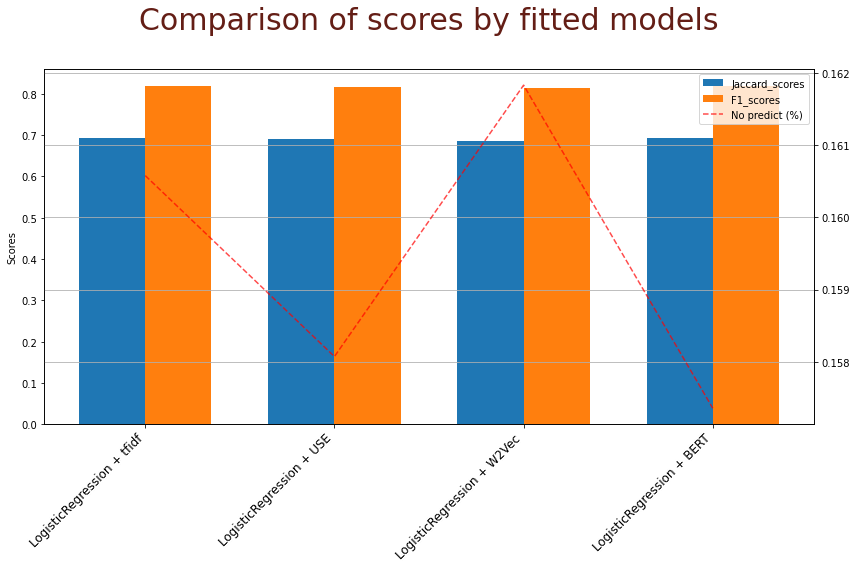

In [ ]:
x = np.arange(len(final_performance.columns[1:5]))
hs=final_performance.iloc[0,:].to_list()
js=final_performance.iloc[1,:].to_list()
fs=final_performance.iloc[2,:].to_list()
hs.remove('hamming_loss')
js.remove('Jaccard')
fs.remove('F1-score')
width = 0.35

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
Jaccard_scores = ax1.bar(x - width/2,js,width,label="Jaccard_scores")
F1_scores = ax1.bar(x + width/2, fs,width,label="F1_scores")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, hs,
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="#641E16", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(labels = final_performance.columns[1:5], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2 , labels +labels2, loc=1,
           fontsize=10)

fig.tight_layout()

plt.show()

Pour La modélisation supervisée de nos données avec les differents types de features extrations,Tfidf, USE, Word2Vec et Bert on remarque que le modèle logistic regression combiné avec USE est plus adaptés sur nos données  

## II- Modèles non supervisés

**1-Non Negative Matrix Factorization (NMF)**

Determinons le nombre de topic optimal pour ce model

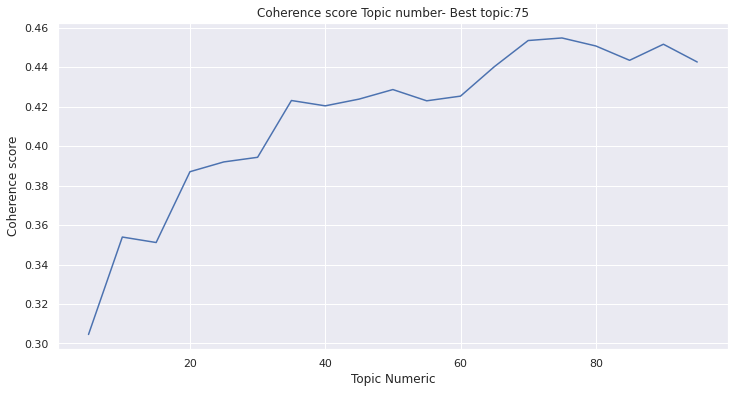

In [43]:
sns.set()
from gensim.models.nmf import Nmf
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
warnings.filterwarnings("ignore")
from gensim.models import TfidfModel
from gensim.corpora.dictionary import Dictionary

# Use Gensim's NMF to get the best num of topics via coherence score
texts= [d.split() for d in docs]
#texts = Dictionary(dataset)
# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in corpus]
# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 100 , 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []

for num in topic_nums:
    nmf = Nmf(
        corpus=tfidf_corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=lambda elem: elem[1], reverse=True)[0][0]
plt.figure(figsize=(12,6))
df=pd.DataFrame({'Topic Numeric': topic_nums,'Coherence score': coherence_scores})
sns.lineplot(x='Topic Numeric',y='Coherence score',data=df)
plt.title('Coherence score Topic number- Best topic:' + str(best_num_topics))
plt.show()

Le score de coherence est maximale au Nombre au topic égale 75. Donc le meilleur nombre de topic pour ce modèle est 75.

In [ ]:
best_num_topics = 75

In [ ]:
nmf = NMF(n_components=best_num_topics,
          random_state=42,
          alpha=0.1)

In [ ]:
from gensim.corpora.dictionary import Dictionary

In [ ]:
nmf.fit(tfidf)

NMF(alpha=0.1, n_components=75, random_state=42)

IndexError: ignored

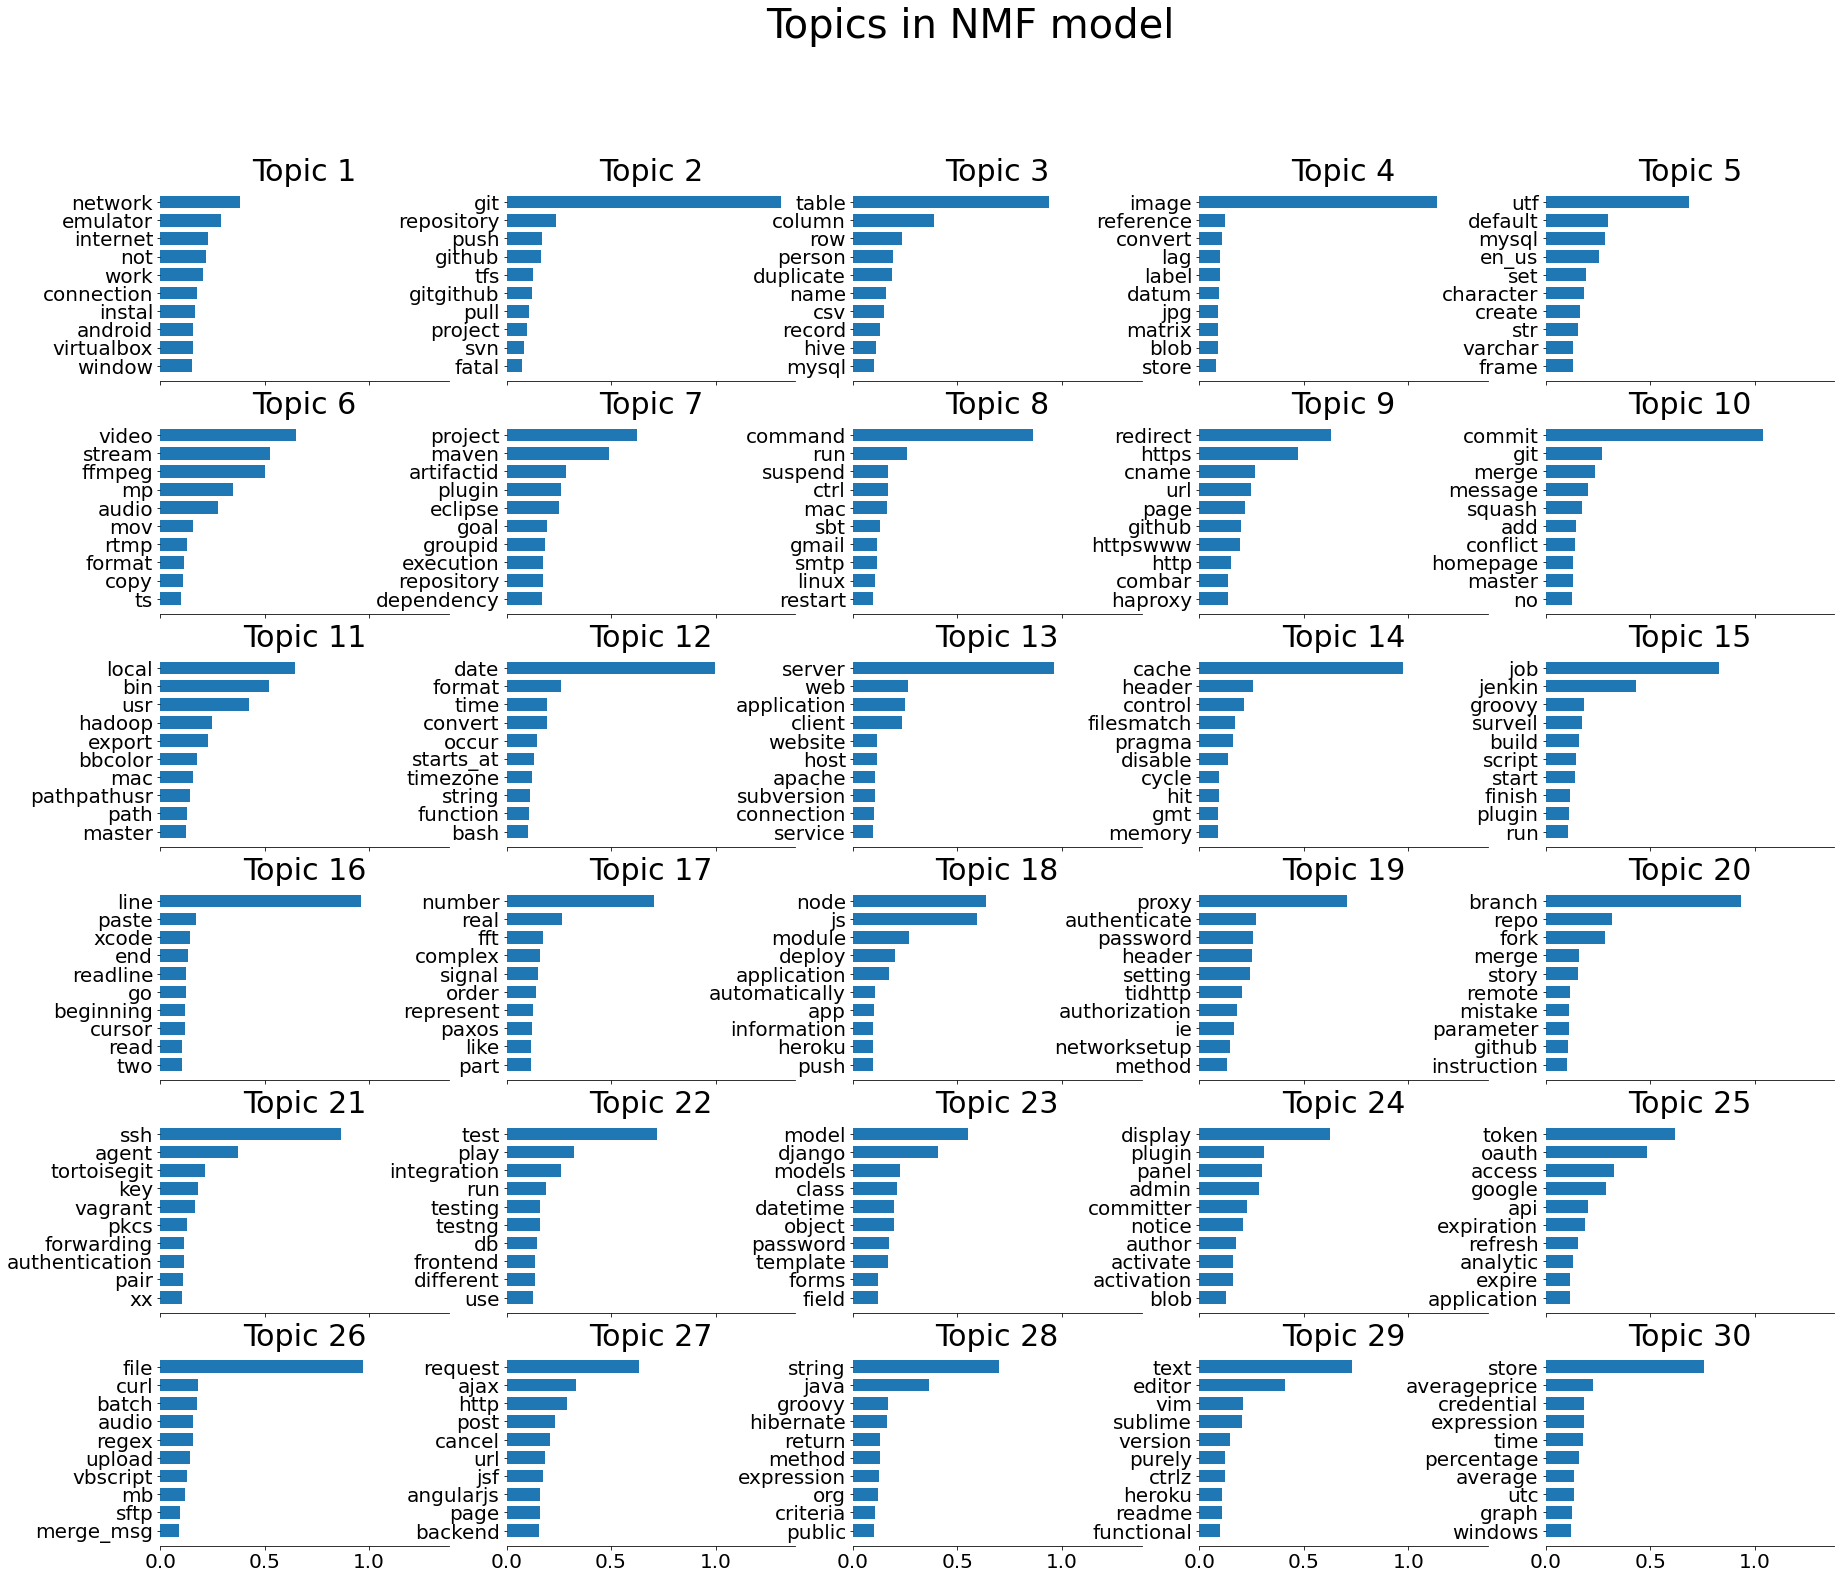

In [40]:
plot_top_words(nmf, tfidf_feature_names, n_top_words=10, title="Topics in NMF model")

In [ ]:
del nmf
gc.collect()

201535

**2-Latent Dirichlet Allocation (LDA)**

In [41]:
#TfidfVectorizer(max_features=12000)
bow_vectorizer = TfidfVectorizer(max_features=12000,ngram_range = (1,1),
                                 tokenizer=tok,max_df=0.5)
docs_bow = bow_vectorizer.fit_transform(docs)

In [44]:
# Create dictionnary (bag of words)
from gensim.corpora.dictionary import Dictionary
texts= [d.split() for d in docs]
id2word = Dictionary(texts)
id2word.filter_extremes(no_below=4, no_above=0.6, keep_n=None)
# Create Corpus 
# Term Document Frequency 
corpus = [id2word.doc2bow(text) for text in texts] 
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in corpus]


On recherche maintenant les meilleurs parametres du modeèle LDA avec gridsearch.

In [ ]:
# Iter LDA for best number of topics
import gensim
import time
from gensim.models.coherencemodel import CoherenceModel

coherence_test = []
for k in np.arange(20,100,5):
    print("Fitting LDA for K = {}".format(k))
    start_time = time.time()
    lda_model = gensim.models.ldamulticore\
                    .LdaMulticore(corpus=tfidf_corpus,
                                  id2word=id2word,
                                  num_topics=k,
                                  random_state=8,
                                  per_word_topics=True,
                                  workers=4)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=texts,
                                         dictionary=id2word,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    coherence_test.append((k, coherence_lda,
                           (end_time - start_time)))

Fitting LDA for K = 20


Fitting LDA for K = 25


Fitting LDA for K = 30


Fitting LDA for K = 35


Fitting LDA for K = 40


Fitting LDA for K = 45


Fitting LDA for K = 50


Fitting LDA for K = 55


Fitting LDA for K = 60


Fitting LDA for K = 65


Fitting LDA for K = 70


Fitting LDA for K = 75


Fitting LDA for K = 80


Fitting LDA for K = 85


Fitting LDA for K = 90


Fitting LDA for K = 95


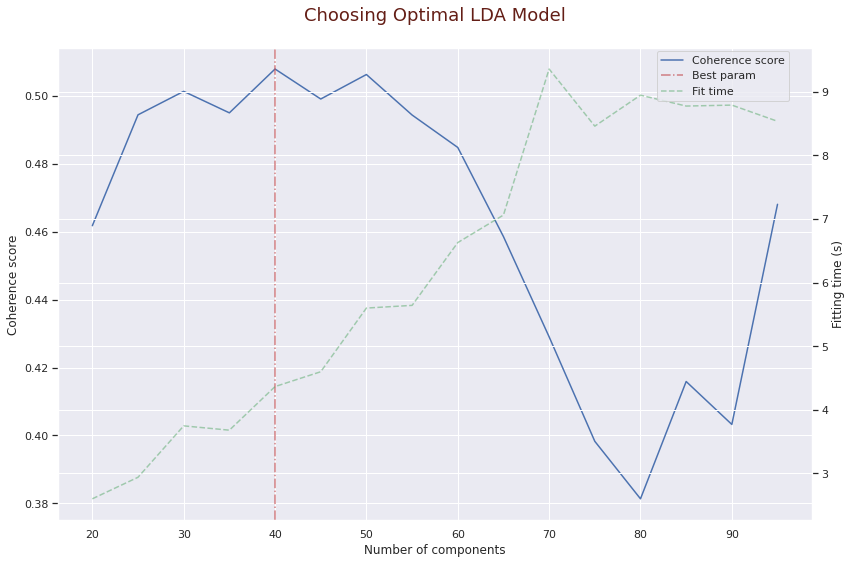

In [ ]:
# Create dataframe of results
sns.set()
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])

# Select best number of topics
best_nb_topics = coherence_test\
                    .loc[coherence_test.coherence.argmax(),"k"]

# Plot results
fig, ax1 = plt.subplots(figsize=(12,8))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]

ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=.7,
            linestyle='dashdot', label='Best param')
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Coherence score")

ax2 = ax1.twinx()
ax2.plot(x, y2, label="Fit time",
         color='g', alpha=.5,
         linestyle='--')
ax2.set_ylabel("Fitting time (s)")

plt.title("Choosing Optimal LDA Model\n",
          color="#641E16", fontsize=18)
legend = fig.legend(loc=1, bbox_to_anchor=(.92, .9))

fig.tight_layout()
plt.show()


In [45]:
lda = LatentDirichletAllocation(random_state=42,
                                batch_size=400)

In [46]:
from numpy.core.function_base import linspace
params = {'n_components' : [40],
          "learning_decay" : [0.5, 0.7, 0.9],
          "learning_method" : ["batch", "online"]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              cv=5,)
gridsearch_lda.fit(docs_bow)

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=42),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [40]})

In [47]:
best_lda_model = gridsearch_lda.best_estimator_

print("Best Model's Params: ", gridsearch_lda.best_params_)
print("Best Log Likelihood Score: ", gridsearch_lda.best_score_)

Best Model's Params:  {'learning_decay': 0.5, 'learning_method': 'batch', 'n_components': 40}
Best Log Likelihood Score:  -22978.98368782003


In [48]:
# Visualize the topics

pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, docs_bow, bow_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
16     -79.145866 -136.017914       1        1  25.062702
22      14.826439 -165.339844       2        1   7.541167
3        4.417876  152.126984       3        1   7.037444
37    -129.094559   63.826565       4        1   6.887313
11     120.131462 -113.959709       5        1   4.486537
0      -66.678505  113.569092       6        1   2.374505
27     101.533951  107.354202       7        1   2.175760
28    -110.263741  -71.163094       8        1   2.000409
2      132.540268   47.862556       9        1   1.997511
23     114.708771  -52.895100      10        1   1.735819
32    -122.380379  -13.269513      11        1   1.706546
24      64.864479   74.229324      12        1   1.674899
1       24.824238   97.687164      13        1   1.607880
25     119.694633   -4.740658      14        1   1.568706
7       18.285036 -110.422050      15        1   1.552378
26     -34.412838 -101.178635      16        1   1.538284
9      -62.054497   58.864307      17        1   1.521724
18      64.086510  -97.658745      18        1   1.496110
21      83.019485   29.155964      19        1   1.464337
29     -86.927338   22.306416      20        1   1.409198
31     -76.989098  -22.279413      21        1   1.406535
19     -22.291340   81.725060      22        1   1.343837
33      11.963715   58.444229      23        1   1.309654
35     -62.910774  -62.561852      24        1   1.283128
20      71.956612  -51.713249      25        1   1.266938
5      -21.773281   40.762676      26        1   1.256657
36      -0.325586  -75.015099      27        1   1.218591
14      76.354004  -12.154736      28        1   1.214314
6      -48.797855   15.930901      29        1   1.199859
4       44.160519   40.345905      30        1   1.184987
38     -27.929495  -54.300900      31        1   1.172790
30     -42.572540  -19.755880      32        1   1.148443
34      37.197536  -66.486450      33        1   1.145672
13      16.401260   -8.511262      34        1   1.144923
8       42.962063  -28.164024      35        1   1.041507
39      45.439140    6.701222      36        1   1.029243
10      12.477527  -42.420563      37        1   1.012813
15     -11.574946  -23.844866      38        1   0.932710
12      12.036592   23.058119      39        1   0.930229
17     -14.796222    6.978681      40        1   0.917940, topic_info=         Term      Freq     Total Category  logprob  loglift
2674      git  9.000000  9.000000  Default  30.0000  30.0000
2340     file  8.000000  8.000000  Default  29.0000  29.0000
29          ]  7.000000  7.000000  Default  28.0000  28.0000
7224     user  4.000000  4.000000  Default  27.0000  27.0000
5321  project  3.000000  3.000000  Default  26.0000  26.0000
...       ...       ...       ...      ...      ...      ...
1019   column  0.059053  1.772881  Topic40  -6.1083   1.2889
5983       se  0.028563  0.413623  Topic40  -6.8346   2.0180
6731      tcp  0.029026  0.437365  Topic40  -6.8186   1.9782
3782    least  0.029486  0.474985  Topic40  -6.8028   1.9114
5904   sample  0.027720  0.535202  Topic40  -6.8646   1.7303

[1628 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.897466        [
1         1  0.782704        \
29        1  0.984239        ]
94        2  0.594012   access
150       2  1.080807    admin
...     ...       ...      ...
7442      1  1.025248      way
7462      3  0.915660  website
7529      1  0.955700     work
7545      1  0.925235    would
7575      1  0.977895        x

[224 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[17, 23, 4, 38, 12, 1, 28, 29, 3, 24, 33, 25, 2, 26, 8, 27, 10, 19, 22, 30, 32, 20, 34, 36, 21, 6, 37, 15, 7, 5, 39, 31, 35, 14, 9, 40, 11, 16, 13, 18])

**3-Evaluation of topic modelling**

In [49]:
dataset = [d.split() for d in docs]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]
tfidf = TfidfModel(corpus)
tfidf_corpus = [tfidf[text] for text in corpus]


In [50]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf

nmf = Nmf(tfidf_corpus, num_topics=75, id2word=common_dictionary)

In [51]:
from gensim.models.ldamodel import LdaModel

lda_best = LdaModel(tfidf_corpus, num_topics=40, id2word=common_dictionary)

In [52]:
from gensim.models.coherencemodel import CoherenceModel

cm_nmf = CoherenceModel(model=nmf, texts=dataset, corpus=tfidf_corpus, coherence='c_v')
coherence_nmf = cm_nmf.get_coherence()
cm_lda = CoherenceModel(model=lda_best, texts=dataset, corpus=tfidf_corpus, coherence='c_v')
coherence_lda = cm_lda.get_coherence()

In [ ]:
print("Coherence Model - NMF: ", coherence_nmf.round(3))
print("Coherence Model - LDA: ", coherence_lda.round(3))

Coherence Model - NMF:  0.529
Coherence Model - LDA:  0.581


Sur les méthodes non supervisés le modèle LDA a la meilleur performance par rapport au NMF. Donc nous sauvagardons ce modèle comme étant le meilleur. 

In [ ]:
joblib.dump(lda_best,'/content/gdrive/My Drive/P5/final_model_lda.pkl')

['/content/gdrive/My Drive/P5/final_model_lda.pkl']

- Affectation des tags pour lda

In [137]:
original_cleaned_keywords = data['Tags']
optimal_model=lda_best
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if  (j == 0 and prop_topic>0.6):  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=tfidf_corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic = pd.concat([df_dominant_topic, original_cleaned_keywords], axis=1)
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Original_keywords']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Original_keywords
0,0,0.0,0.7207,"image, date, percentage, tunnel, mp, bidirecti...",static option gcc wonder static option gcc nee...,"optimization, gcc, compiler-construction, sta..."
1,1,38.0,0.8094,"line, route, character, test, endpoint, db, te...",file group record unit separator control chara...,"text, unicode, ascii, history, control-charac..."
2,2,35.0,0.7948,"domain, language, label, git, decision, branch...",read file line line go unable find file readli...,"string, file, parsing, go, line"
3,3,30.0,0.8620,"categorical, youtube, json, slfj, pinter, valu...",provide relevant result multiple factor weight...,"algorithm, sorting, bayesian, relevance, weig..."
4,4,21.0,0.7591,"package, hive, hadoop, uibutton, brew, nuget, ...",haar cascade vs lbp cascade face detection exp...,"opencv, cascade, face-detection, haar-wavelet..."
5,5,13.0,0.8232,"kdiff, committer, jenkin, branch, py, log, gma...",website pksc smart card authentication ssl cli...,"http, authentication, ssl, smartcard, pkcs#11"
6,6,24.0,0.7946,"image, job, responsibility, shadow, file, cros...",git tag list display commit sha hash git tag c...,"git, logging, hash, git-tag, verbose"
7,7,34.0,0.7184,"`, segment, image, tst, js, \, todo, project, ...",I find list homebrew installable package recen...,"list, macos, installation, package, homebrew"
8,8,3.0,0.7981,"keyval, `, job, room, list, super, button, use...",gerrit error change id commit message miss set...,"git, merge, branch, master, gerrit"
9,9,28.0,0.8364,"tfs, heap, commit, utc, popover, time, byte, n...",I transfer file sftp take long ftp manually co...,"performance, file, ftp, sftp, transfer"


Document le plus significatif par topic

In [138]:
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8584,"image, date, percentage, tunnel, mp, bidirecti...",comparison subversion server visualsvn collabn...
1,1.0,0.8422,"statement, vbscript, h[, mysql, view, method, ...",browser apis restrict cross domain request xml...
2,2.0,0.8579,"plug, bind, type, color, filename, version, fa...",wcf data service odata vs asp net web api desi...
3,3.0,0.8611,"keyval, `, job, room, list, super, button, use...",handle facebook sharing like hashbang url buil...
4,4.0,0.8199,"nginx, git, gitgithub, controller, current_tim...",prevent file direct url access use apache samp...


In [139]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf[["Topic_Num","Keywords"]]

# Concatenate Column wise
df_dominant_topics_prop = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics_prop.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics_prop.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"image, date, percentage, tunnel, mp, bidirecti...",16,0.0325
1.0,1.0,"statement, vbscript, h[, mysql, view, method, ...",13,0.0264
2.0,2.0,"plug, bind, type, color, filename, version, fa...",12,0.0244
3.0,3.0,"keyval, `, job, room, list, super, button, use...",13,0.0264
4.0,4.0,"nginx, git, gitgithub, controller, current_tim...",8,0.0163


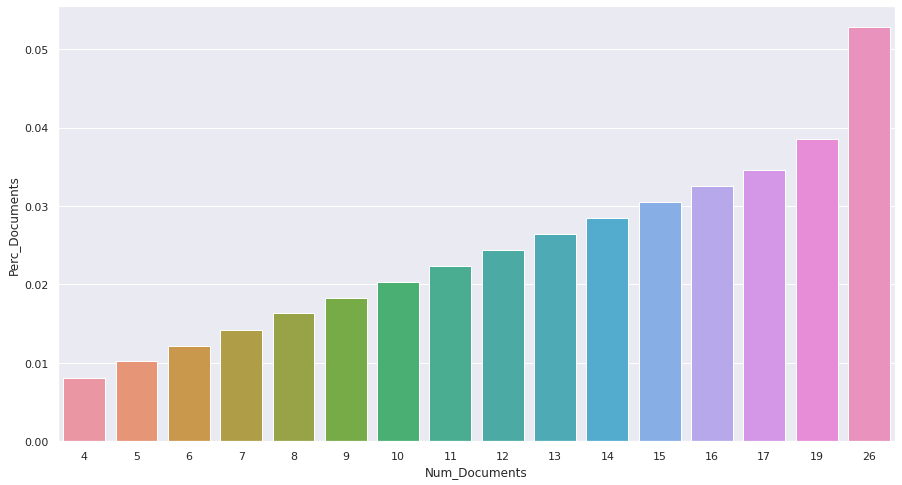

In [147]:
plt.figure(figsize=(15,8))
sns.barplot(x='Num_Documents',y='Perc_Documents',data=df_dominant_topics_prop)

 Pour attribuer des Tags à chaque question sur ces modèles non-supervisés, nous allons créer une matrice Topic/Tags en réalisant une multiplication matricielle des matrices Document / Topic et Document / Tags.
 
 Nous allons donc créer nos prédictions en prenant les n
  premiers tags associés aux topics de chaque document :

In [ ]:
def affect_tags(model):
  # Calculate Document/topic matrix with Gensim
  doc_topic = pd.DataFrame(model\
                             .get_document_topics(corpus,
                                                  minimum_probability=0))
  for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

  # Matricial multiplication with Document / Topics transpose
  topic_tag = np.matmul(doc_topic.T, tags_mlb)
  y_results = pd.DataFrame(data['Tags'])
  y_results["best_topic"] = doc_topic.idxmax(axis=1).values
  y_results["nb_tags"] = y_results["Tags"].apply(lambda x : len(x))

  df_y_bin = pd.DataFrame(tags_mlb)
  df_dict = dict(list( df_y_bin.groupby(df_y_bin.index)))
  
  tags_num = []
  for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())
  y_results["y_true"] = tags_num

  # Select predicted tags in Topics / Tags matrix
  list_tag = []
  for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
  y_results["y_pred"] = list_tag
  return y_results


In [ ]:
affect_tags(lda_best)

,Tags,best_topic,nb_tags,y_true,y_pred
0,"optimization, gcc, compiler-construction, sta...",1,58,"[0, 3, 4, 16, 18, 20, 22, 24, 27, 28, 29, 30, ...","[0, 3, 20, 24, 16, 35, 33, 30, 29, 34, 18, 28,..."
1,"text, unicode, ascii, history, control-charac...",15,50,"[0, 3, 4, 16, 18, 19, 20, 23, 24, 27, 29, 30, ...","[0, 3, 34, 35, 16, 24, 20, 29, 18, 33, 30, 31,..."
2,"string, file, parsing, go, line",2,32,"[0, 3, 16, 20, 21, 22, 24, 27, 29, 30, 31, 33,...","[0, 3, 20, 29, 34, 16, 35, 33, 24, 27, 30, 22,..."
3,"algorithm, sorting, bayesian, relevance, weig...",5,58,"[0, 3, 4, 16, 17, 18, 19, 20, 22, 23, 24, 27, ...","[0, 3, 20, 24, 16, 34, 35, 18, 33, 30, 23, 29,..."
4,"opencv, cascade, face-detection, haar-wavelet...",0,59,"[0, 3, 4, 16, 18, 19, 20, 21, 23, 24, 25, 27, ...","[0, 3, 24, 20, 35, 30, 29, 34, 18, 16, 33, 27,..."
...,...,...,...,...,...
527,"dynamic, configuration, url-routing, angularj...",19,57,"[0, 3, 4, 16, 18, 19, 20, 21, 22, 24, 25, 27, ...","[0, 3, 16, 20, 34, 35, 24, 33, 29, 30, 28, 27,..."
528,"algorithm, graph-theory, shortest-path, dijks...",5,57,"[0, 3, 4, 16, 19, 20, 22, 23, 24, 25, 26, 27, ...","[0, 3, 20, 24, 16, 34, 35, 18, 33, 30, 23, 29,..."
529,"networking, windows-8, hyper-v, windows-phone...",14,74,"[0, 3, 4, 14, 16, 19, 20, 22, 23, 24, 26, 27, ...","[0, 3, 20, 24, 31, 29, 34, 16, 33, 35, 27, 30,..."
530,"centos, virtualization, virtualbox, chmod, va...",1,51,"[0, 3, 16, 17, 18, 19, 20, 22, 23, 24, 27, 28,...","[0, 3, 20, 24, 16, 35, 33, 30, 29, 34, 18, 28,..."


In [ ]:
from numpy.lib.function_base import average
def metrics_score(model,y_true, y_pred):
  model_y_pred = np.zeros(tags_mlb.shape)
  n = 0
  for row in y_pred:
    for i in range(len(row)):
      model_y_pred[n,row[i]] = 1
    n+=1
  model_y_true = np.zeros(tags_mlb.shape)
  m = 0
  for row in y_true:
    for i in range(len(row)):
      model_y_true[m,row[i]] = 1
    m+=1
  y_true=model_y_true
  y_pred=model_y_pred
  
  temp_df = pd.DataFrame(index=['hamming_loss',"Jaccard", "F1-score",
                                  ],
                               columns=[model])
  scores = []
  scores.append(metrics.hamming_loss(y_true, y_pred))
  scores.append(metrics.jaccard_score(y_true, 
                                        y_pred, 
                                        average='micro'))
  scores.append(metrics.f1_score(y_pred, 
                                   y_true, 
                                   average='micro'))
     
  temp_df[model] = scores  
  return temp_df

In [ ]:
df_metrics_compare = metrics_score('LDA',affect_tags(lda_best).y_true,affect_tags(lda_best).y_pred)
df_metrics_compare

,LDA
hamming_loss,0.513561
Jaccard,0.470173
F1-score,0.639616


- **Comparaison modèle supervisé et non supervisé**

In [ ]:
Performance_S_NS=final_performance
Performance_S_NS['LDA']=df_metrics_compare.iloc[:,0].values
Performance_S_NS

NameError: ignored

In [ ]:
dump(Performance_S_NS, open('/content/gdrive/My Drive/P5/Performance_S_NS.pkl', 'wb'))

- **Sélection du modèle final**

Pour sélectionner le modèle final, nous allons nous baser sur les scores obtenus aux métriques Jaccard et F1. Nous prendrons également en compte le taux de "non prédits" pour trouver le meilleur compromis entre tout ces indicateurs de performance.

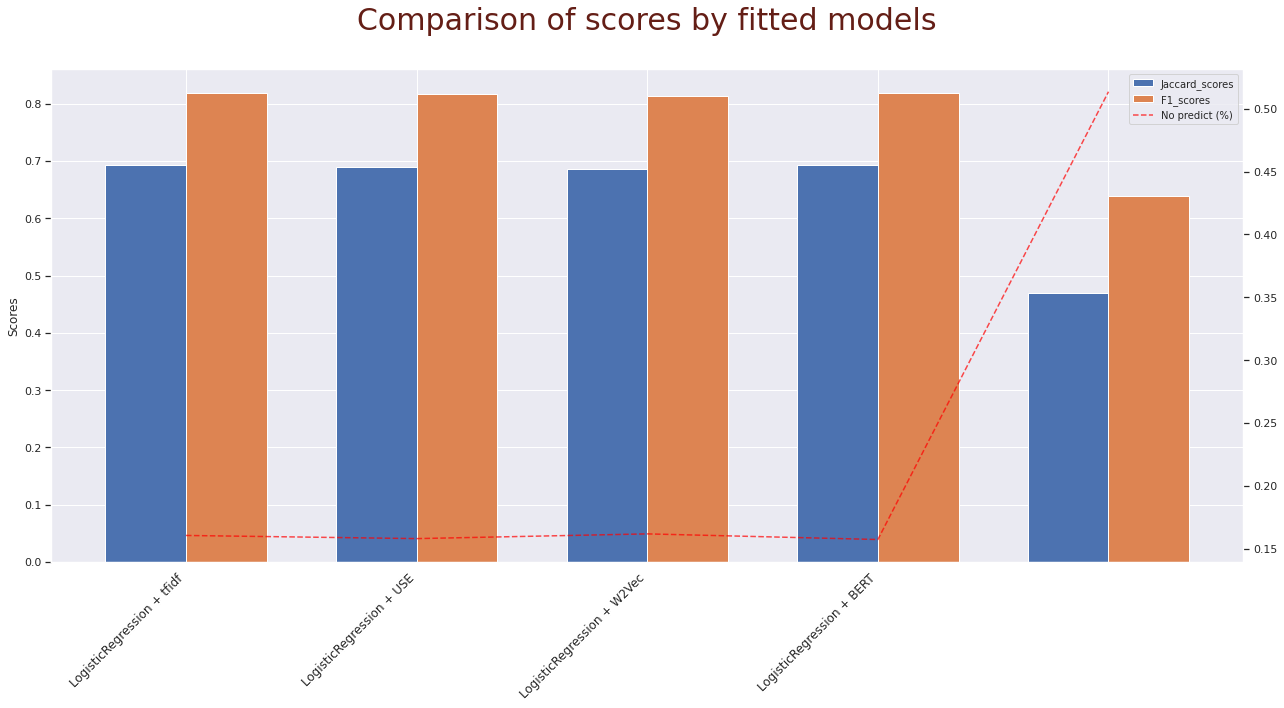

In [ ]:
x = np.arange(len(Performance_S_NS.columns[1:6]))
h=Performance_S_NS.iloc[0,:].to_list()
j=Performance_S_NS.iloc[1,:].to_list()
f=Performance_S_NS.iloc[2,:].to_list()
h.remove('hamming_loss')
j.remove('Jaccard')
f.remove('F1-score')
width = 0.35

fig = plt.figure(figsize=(18,10))
ax1 = fig.add_subplot(111)
Jaccard_scores = ax1.bar(x -width/2,j,width,label="Jaccard_scores")
F1_scores = ax1.bar(x + width/2, f,width,label="F1_scores")

ax2 = ax1.twinx()
non_predict = ax2.plot(x, h,
                       linestyle='--',
                       color="red", alpha=.7,
                       label='No predict (%)')
ax2.grid(None)

ax1.set_ylabel('Scores')
ax1.set_title('Comparison of scores by fitted models\n',
              color="#641E16", 
              fontdict={'fontsize': 30})
ax1.set_xticks(x)
ax1.set_xticklabels(labels = final_performance.columns[1:5], 
                      rotation=45,
                     horizontalalignment='right',
                     size=12,
                     )
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2 , labels+labels2 , loc=0,
           fontsize=10)


fig.tight_layout()

plt.show()

On peut constater que le modèle logisticRegression  offre le meilleur compromis entre le taux de valeur prédites et les métriques Jaccard, F1. Ce modèle est donc le meilleur modèle testé et devrait être sélectionné pour notre problématique de proposition de Tags Stockoverflow.

In [ ]:
final_model=Pipeline([('model',OneVsRestClassifier(LogisticRegression(C=1.0, penalty='l2', solver='sag',random_state=1)))])
final_model.fit(X_train_use,y_train)
joblib.dump(final_model,'/content/gdrive/My Drive/P5/final_model_pipeline.pkl')

['/content/gdrive/My Drive/P5/final_model_pipeline.pkl']

#Reference

- https://towardsdatascience.com/the-triune-pipeline-for-three-major-transformers-in-nlp-18c14e20530
- https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
-https://pyldavis.readthedocs.io/en/latest/readme.html